In [1]:
"""IMPORTING"""
import json
from pprint import pprint
from moviepy.editor import *
import cv2
from scipy import integrate
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import sys

frame_time = []
truth_speed = []
frame_json = []
state = []
index = 1;

"""SETTING HIGHWAY VS CITY"""
# highway = 1, city = 0
with open('drive.json') as data_file:
    data = json.load(data_file)

for frame in data:
    frame_time.append(frame[0])
    truth_speed.append(frame[1])
    frame_json.append(index)
    index += 1

for frame in range(0,3000):
     state.append('b')

for frame in range(3001,5420):
    state.append('r')

for frame in range(5421, 5600):
    state.append('b')

for frame in range(5601, 8000):
    state.append('r')

for frame in range(8001, 8616):
    state.append('b')

"""FUNCTIONS"""
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.

    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.

    References
    ----------
    [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def region_of_interest(img, vertices):
    # Image masking
    # Creating blank mask of zeroes
    mask = np.zeros_like(img)

    # Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # Grabbing the number of channels
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Returning the image only where mask pixels are non-zero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def gaussian_noise(img, kernel_size):
    # Blur, kernal size determines blurriness
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def derivative(previous_image, current_image):
    height = current_image.shape[0]
    width = current_image.shape[1]
    current = np.array(gaussian_noise(cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY), 15),dtype=np.float)
    previous = np.array(gaussian_noise(cv2.cvtColor(previous_image, cv2.COLOR_BGR2GRAY), 15),dtype=np.float)
    blank_image = np.zeros((height,width,3),np.float) #Creating blank image size of frame
    blank_image = (current - previous)
    derivative =  np.array(blank_image,dtype=np.float) # float to int
    matrix_score = math.sqrt(np.sum(derivative)**2)
    return { "derivative": derivative, "score": matrix_score }

"""PROCESSING FLOW"""
# Structure Inits
frame_no = 1
height = 0
width = 0
frame_list = []
time_list = []
image_array = [] # queue of the last five images for smooothing algo
derivate_array = []
score_array = [ 0 ]
rms = 0

import imageio
video = imageio.get_reader('drive.mp4')

for i, image in enumerate(video):
    if image is not None:
        height = image.shape[0]
        width = image.shape[1]
        region = np.array([[(width/2,8*height/9),(width/2, 5*height/9), (width, 5*height/9), (width,8*height/9)]], dtype=np.int32)
        image = region_of_interest(image, region)
        image_array.append(image) #adding frames to image buffer
        if len(image_array) == 2:
            d_frame = derivative(image_array[0],image_array[1])
            score_array.append(d_frame["score"])
            del image_array[0]
            if frame_no % 1000 == 0:
                print(frame_no)

    frame_list.append(frame_no)
    frame_no += 1
    if frame_no == 10000:
        break

print("Complete!")
"""CLOSING VIDEO"""
video.close()


1000
2000
3000
4000
5000
6000
7000
8000
Complete!


Check - 1
Check - 2
Check - 3
Check - 4
Check - 5


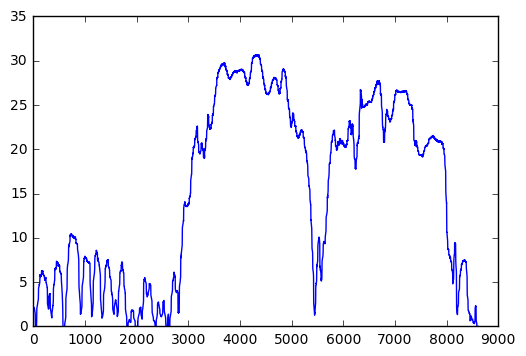

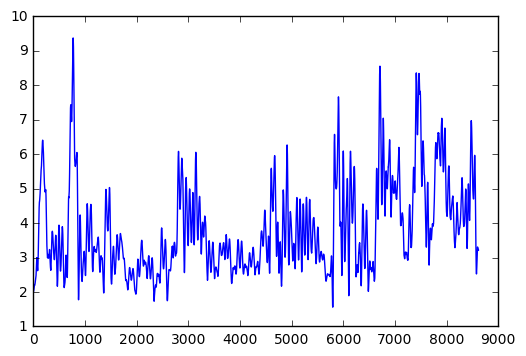

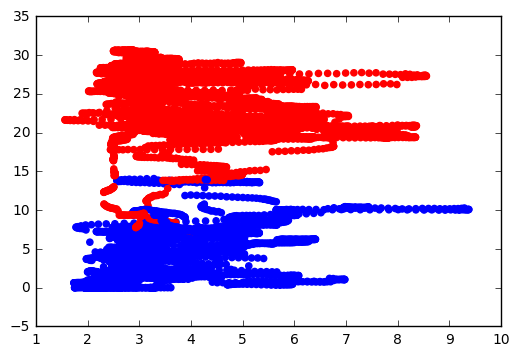

Check - 7
RMSE: 15.254743997909245


In [4]:
"""CALCULATIONS"""
print("Check - 1")
score_arr = np.array(score_array)
frame_list = np.array(frame_list)

print("Check - 2")
filtered = savitzky_golay(savitzky_golay(score_arr, 201, 9), 51, 3) # window size 51, polynomial order 3

print("Check - 3")
# y = m * x + b
filtered = (12 * filtered + 2)

# NEXT, ROUND SPEEDS!!!!

print("Check - 4")
frame_list = frame_list[:frame_no+1]
scores = filtered[:frame_no+1]
frame_json = frame_json[:len(frame_list)]
truth_speed = truth_speed[:len(frame_list)]
state = state[:len(frame_list)]

print("Check - 5")
"""PLOTTING"""
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(frame_json, truth_speed)

fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.plot(frame_list, scores)

plt.show()

plt.scatter(scores, truth_speed, color = state)
plt.show()

print("Check - 7")
from sklearn.metrics import mean_squared_error
rms  = math.sqrt(mean_squared_error(truth_speed, filtered))
print("RMSE:",rms)

[[  4.83672332   3.57691457]
 [ 24.11107005   4.03641584]]


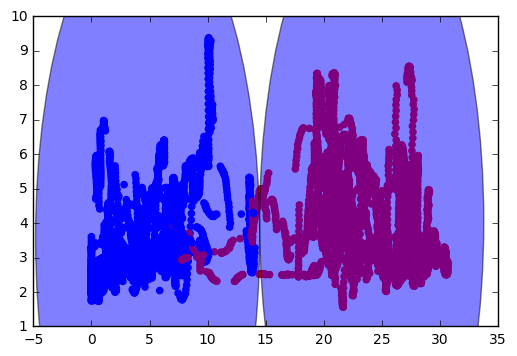

In [5]:
from sklearn.cluster import KMeans

mat = []
i = 0

for i in range(0,len(scores)):
    mat.append([truth_speed[i],scores[i]])

kmeans = KMeans(n_clusters=2, random_state=0).fit(mat)
centers = kmeans.cluster_centers_

print(centers)

yc = [centers[0][0],centers[1][0]]
xc = [centers[0][1],centers[1][1]]
r = math.sqrt((yc[1]-yc[0])**2+(xc[1]-xc[0])**2)

plt.scatter(truth_speed, scores, color = state)

circle1 = plt.Circle((yc[0],xc[0]), radius=r/2, alpha=0.5)
plt.gca().add_patch(circle1)
circle2 = plt.Circle((yc[1],xc[1]), radius=r/2, alpha=0.5)
plt.gca().add_patch(circle2)


plt.show()